# Sanity check for STDP visualizing
Les poids sont fixes et non plus normaux, pour faciliter la visualisation

## D'après le super papier de Froemke and Dan 2002 :
A+ = 103 %, A- = 51%

theta+ = 13.3 ms, theta- = 34.5ms

# 1/ Visualiser les poids du ring après son apprentissage

In [1]:
import numpy as np
import pyNN.nest as sim
from pyNN.random import NumpyRNG
from pyNN.random import RandomDistribution as rnd
import matplotlib.pyplot as plt
from lmfit.models import GaussianModel
import lmfit
import matplotlib.gridspec as gridspec

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


/home/hugo/anaconda3/lib/python3.7/site-packages/PyNN-0.9.2-py3.7.egg/pyNN/nest/__init__.py:55: UserWarning: Unable to install NEST extensions. Certain models may not be available.
Further details: DynamicModuleManagementError in Install: Module 'pynn_extensions' could not be opened.
The dynamic loader returned the following error: 'file not found'.

Please check LD_LIBRARY_PATH (OSX: DYLD_LIBRARY_PATH)!
  warnings.warn("Unable to install NEST extensions. Certain models may not be available.\nFurther details: {}".format(err))


In [2]:
def fit_plot(popsize, spike_array, ax, datacol = '.r', fitcol = '--k', data_kws = None, do_title = True,
            seq_nbr= None):
    '''
    calculates a spike array gaussian lmfit profile and plots it
    '''
    #extracts the spiketrains
    
    #fit the gaussian
    x = np.linspace(0, popsize, popsize)
    y = spike_array

    mod = GaussianModel()
    pars = mod.guess(y, x=x)
    #pars['center'] = lmfit.Parameter('center', seq_nbr*15)
    out = mod.fit(y, pars, x=x)
    #print(out.fit_report(min_correl=0.25))
    
    #plot the fits
    out.plot_fit(ax = ax, datafmt = datacol, fitfmt = fitcol, data_kws = data_kws)
    
    #eye cancer-triggering lines
    sigma = out.best_values['sigma']

    
    if do_title :
        ax.set_title('Sequence #%s -- ' % seq_nbr + r'$\sigma$ = %.2f'%sigma)
    
    return ax, sigma
    
def tuning_function(i, j, B, N): #von mises
        if B==np.inf:
            VM = np.ones_like(i*j)
        else:
            VM = np.exp((np.cos(2.*((i-j)/N*np.pi))-1)/(B*np.pi/180)**2)
        VM /= VM.sum(axis=0)
        return VM
    
def vary_angle(t):
    '''
    callback function that shifts the maximum angle
    '''
    
    simtime = 2000
    n_pop = 60
    shift = 40
    
    angle = 1. * np.arange(n_pop)
    rates = tuning_function(angle, (t*shift)+(angle_input)/180.*n_pop, b_theta, n_pop)
    rates /= rates.mean()
    rates *= rate_gain
    for i, cell in enumerate(input_pop):
        cell.set_parameters(rate=rates[i])
        
    return t + simtime/4

def cut_spiketrain(array, window):
    '''
    Cut a spiketrain array between window*500 and window+1 *500
    we use it to only visualize a specific time window of the network
    '''
    spiketrain_len = []
    for spiketrain in np.asarray(array.spiketrains):
        spiketrain_array = np.array(spiketrain, dtype = float)
        
        spiketrain_cut = np.where((spiketrain_array > window*500) & (spiketrain_array < (window+1)*500))[0]
        
        spiketrain_len.append(len(spiketrain_cut))
    
    spikelen_array = np.asarray(spiketrain_len)
    return spikelen_array

In [3]:
def SuperPlotter(SpikesP, SpikesE, SpikesI, 
                 popsize, rates, simtime,
                 title = 'Title', markersize = .5,
                         figsize = (9,6), shifts = None):
        def plot_spiketrains(ax, spikes, color, ylabel, do_ticks): #oh la jolie double fonction
            for spiketrain in spikes.spiketrains:
                y = np.ones_like(spiketrain) * spiketrain.annotations['source_id']
                ax.scatter(spiketrain, y, color = color, s = markersize)
                ax.set_ylabel(ylabel)
                if not do_ticks : ax.set_xticklabels([])
                if shifts != None :
                    for i, times in enumerate(shifts): ax.axvline(x = times, color = 'k',
                                                                 linestyle = '-.', linewidth = 1)
                        
        fig = plt.figure(figsize = figsize)
        gs = gridspec.GridSpec(3, 8)
        axs1 = plt.subplot(gs[0, :4])
        axs2 = plt.subplot(gs[1, :4])
        axs3 = plt.subplot(gs[2, :4])
        
        axs4 = plt.subplot(gs[0:1 , 4:6])
        axs5 = plt.subplot(gs[0:1 , 6:8])
        axs6 = plt.subplot(gs[1:2 , 4:6])
        axs7 = plt.subplot(gs[1:2 , 6:8])
        
        #what a fucking mess
        min_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[0])
        max_poisson = int(SpikesP.description.split('ID range')[1].split('\n')[0].split(': ')[1].split('-')[1])
        axs1.set_ylim(min_poisson, max_poisson)
        
        plot_spiketrains(axs1, SpikesP, color = 'g', ylabel = 'Neuron Index', do_ticks = False)
        axs1.set_title('Poisson input')
        plot_spiketrains(axs2, SpikesI, color = 'b', ylabel = 'Neuron Index', do_ticks = False)
        axs2.set_title('Inhibitory population')
        plot_spiketrains(axs3, SpikesE, color = 'r', ylabel = 'Neuron Index', do_ticks = True)
        axs3.set_title('Excitatory population')
        axs3.set_xlabel('Time(ms)')
        
        axs4.plot(cut_spiketrain(SpikesP, 0), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 0) , axs4, seq_nbr = 1)[1]
        axs4.set_xticklabels([])
        axs4.set_yticklabels([])
        axs4.set_xlabel('')
        axs4.set_ylabel('')
        
        axs5.plot(cut_spiketrain(SpikesP, 1), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 1) , axs5, seq_nbr = 2)[1]
        axs5.set_xticklabels([])
        axs5.set_yticklabels([])
        axs5.set_xlabel('')
        axs5.set_ylabel('')
        
        axs6.plot(cut_spiketrain(SpikesP, 2), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 2) , axs6, seq_nbr = 3)[1]
        axs6.set_xticklabels([])
        axs6.set_yticklabels([])
        axs6.set_xlabel('')
        axs6.set_ylabel('')
        
        axs7.plot(cut_spiketrain(SpikesP, 3), color = 'g')
        fit_plot(popsize, cut_spiketrain(SpikesE, 3) , axs7, seq_nbr = 4)[1]
        axs7.set_xlabel('Neuron index')
        axs7.set_ylabel('Sequence spikes', rotation = 270)
        axs7.yaxis.tick_right()
        axs7.yaxis.set_label_position("right")
        
        fig.suptitle(title, fontsize=12)
        plt.show()
        return fig

# Simulation

In [4]:
n_pop = 60
neuron_parameters = {'cm': .5,  # nF - McCormick
                     'e_rev_E': 0.0,  # mV - McCormick but default values
                     'e_rev_I': -70.0,  # mV - McCormick but default values
                     'tau_m': 30,  # ms - Markram
                     'tau_refrac': 1.5,  # ms - McCormick
                     'tau_syn_E': 0.25,  # ms -McCormick
                     'tau_syn_I': 0.75,  # ms - McCormick
                     'v_reset': -56.5,  # mV - McCormick
                     'v_rest': -65.5,  # mV - McCormick
                     'v_thresh': -52.5,  # mV - McCormick
                     }

simtime = 2000
rng = sim.NumpyRNG(seed=42)

rate_gain = 10.  # multiplier for the rates
angle_input = 40  # degrees
b_theta = 30  # degrees
sparseness = .1

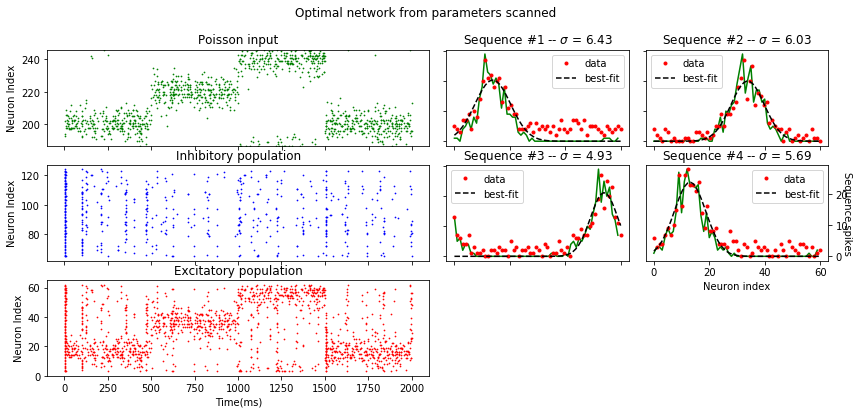

In [5]:
stdp_weight_init = 1
normal_weights = stdp_weight_init

delays = rnd('normal_clipped', mu=1, sigma=.5, low=0.1,
             high=5,
             rng=rng)

timing_dependence=sim.SpikePairRule(tau_plus=30., tau_minus=30.,
                                    A_plus=1, A_minus=10)


stdp_max_w = 2 * stdp_weight_init

sim.setup(timestep=.1, threads=4)
exc = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Exictateurs")

inh = sim.Population(n_pop, sim.IF_cond_exp(**neuron_parameters),
                     initial_values={"v": neuron_parameters["v_reset"]},
                     label="Neurones Inhibiteurs")

input_pop = sim.Population(n_pop,
                           sim.SpikeSourcePoisson(
                               rate=500, duration=simtime, start=0),
                           label="Entree Orientation")


STDP_syn = sim.STDPMechanism(
    timing_dependence=timing_dependence,
    weight_dependence=sim.AdditiveWeightDependence(w_min=0, w_max=stdp_max_w),
    weight=stdp_weight_init,
    delay=delays,
    dendritic_delay_fraction=1.)

# Intras
syn_exc_exc = sim.Projection(exc, exc,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=STDP_syn,
                             receptor_type='excitatory')
syn_inh_inh = sim.Projection(inh, inh,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=sim.StaticSynapse(
                                 weight=normal_weights, delay=delays),
                             receptor_type='inhibitory')  # we can't have two types of synapses now can we ?

# Inters
syn_exc_inh = sim.Projection(exc, inh,
                             connector=sim.FixedProbabilityConnector(
                                 sparseness, rng=rng),
                             synapse_type=STDP_syn,
                             receptor_type='excitatory')
syn_inh_ex = sim.Projection(inh, exc,
                            connector=sim.FixedProbabilityConnector(
                                sparseness, rng=rng),
                            synapse_type=sim.StaticSynapse(
                                weight=normal_weights, delay=delays),
                            receptor_type='inhibitory')

# Input
syn_inp_exc = sim.Projection(input_pop, exc,
                             connector=sim.OneToOneConnector(),
                             synapse_type=sim.StaticSynapse(
                                 weight=1, delay=1),
                             receptor_type='excitatory')

angle = 1. * np.arange(n_pop)
rates = tuning_function(angle, angle_input/180.*n_pop, b_theta, n_pop)
rates /= rates.mean()
rates *= rate_gain
for i, cell in enumerate(input_pop):
    cell.set_parameters(rate=rates[i])

exc.record('spikes')
inh.record('spikes')
input_pop.record('spikes')
sim.run(simtime, callbacks=[vary_angle])
sim.end()

exc_data = exc.get_data().segments[0]
inh_data = inh.get_data().segments[0]
inp_data = input_pop.get_data().segments[0]

fig = SuperPlotter(inp_data, exc_data, inh_data,
             60, rates, simtime,
             title= 'Optimal network from parameters scanned',
             figsize = (14,6)
             )
#fit_plot(n_pop, exc_data)

plt.show()
#fig.savefig('./figs/2018_12_11_Optim_ring_shifts.pdf', format = 'pdf', dpi = 200)

In [6]:
end_w = syn_exc_exc.get("weight", format = "list", with_address = False)
delta_w = np.asarray(end_w) - stdp_weight_init

Text(0.5, 1.0, 'Poids intras des neurones excitateurs du ring')

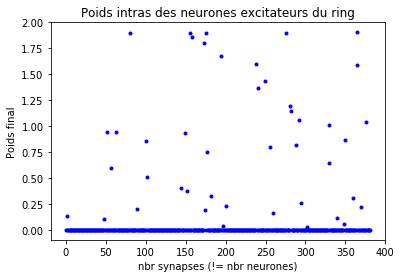

In [7]:
plt.plot(end_w, '.b')
plt.xlabel('nbr synapses (!= nbr neurones)')
plt.ylabel('Poids final')
plt.title('Poids intras des neurones excitateurs du ring')

Text(0.5, 1.0, 'Plasticité des neurones excitateurs du ring')

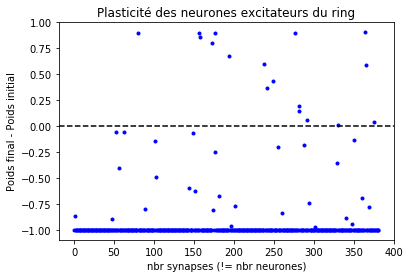

In [8]:
plt.plot(delta_w, '.b')
plt.axhline(0, c='k', linestyle = '--')
plt.xlabel('nbr synapses (!= nbr neurones)')
plt.ylabel('Poids final - Poids initial')
plt.title('Plasticité des neurones excitateurs du ring')

# 2/Visualisation des constantes de temps de STDP dans un réseau simplifié

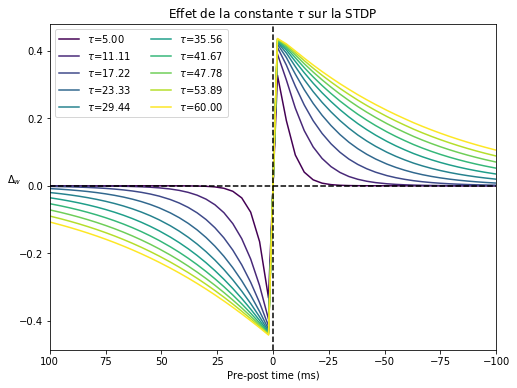

In [9]:
import logging
import math
import numpy
import pylab
import random
import sys
from pyNN.parameters import Sequence
import pyNN.nest as sim
import numpy as np
import matplotlib.pyplot as plt

#VOIR BI AND PO 98 POUR LES DATAS
time_between_pairs = 1000
num_pairs = 60
start_w = .5
delta_t = np.linspace(-100, 100, 50, dtype=int)

start_time = 200

def simulate(sim, tau_minus, setup_kwargs):
    # Population parameters
    tau_plus = tau_minus
    model = sim.IF_curr_exp
    cell_params = {'cm': 0.25,  # nF
                   'i_offset': 0.0,
                   'tau_m': 10.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 2.5,
                   'tau_syn_I': 2.5,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -55.4}

    # SpiNNaker setup
    sim.setup(timestep=0.1, **setup_kwargs)
    sim_time = (num_pairs * time_between_pairs) + max(delta_t)

    # Neuron populations
    pre_pop = sim.Population(len(delta_t), model(**cell_params), label="pre")
    post_pop = sim.Population(len(delta_t), model(**cell_params), label="post")

    # Stimulating populations
    pre_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="pre_stim")
    post_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="post_stim")

    # Build stimulus spike times
    for i, t in enumerate(delta_t):
        # Pre after post
        if t > 0:
            post_phase = start_time
            pre_phase = start_time + t + 1
        # Post after pre
        else:
            post_phase = start_time - t
            pre_phase = start_time + 1

        pre_stim[i].spike_times = Sequence(
            range(pre_phase, sim_time, time_between_pairs))
        post_stim[i].spike_times = Sequence(
            range(post_phase, sim_time, time_between_pairs))

    # Connections between spike sources and neuron populations
    ee_connector = sim.OneToOneConnector()
    ee_synapse = sim.StaticSynapse(weight=2.0, delay=1.0)
    sim.Projection(pre_stim, pre_pop, ee_connector, ee_synapse)
    sim.Projection(post_stim, post_pop, ee_connector, ee_synapse)

    timing_dependence = sim.SpikePairRule(tau_plus=tau_plus, tau_minus=tau_minus,
                                          A_plus=.01, A_minus=.01)

    # Plastic Connection between pre_pop and post_pop
    stdp_model = sim.STDPMechanism(
        timing_dependence=timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=start_w*2),  # 200% max voir papier
        weight=start_w,
        delay=1,
        dendritic_delay_fraction=1.)

    plastic_proj = sim.Projection(
        pre_pop, post_pop, sim.OneToOneConnector(), stdp_model)

    sim.run(sim_time)

    end_w = plastic_proj.get("weight", format="list", with_address=False)

    sim.end()

    return end_w


figure, axis = plt.subplots(figsize=(8, 6))
axis.set_xlabel(r"Pre-post time (ms)")
axis.set_ylabel(r"$\Delta_w$", rotation="horizontal")

colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i, tau_minus in enumerate(np.linspace(5, 60, 10)):
    end_w = simulate(sim, tau_minus, {"spike_precision": "on_grid"})

    delta_w = [(w - start_w) / start_w for w in end_w]
    axis.plot(delta_t, delta_w, label="$\\tau$=%.2f" % tau_minus,
              color=colors[i])
    axis.set_xlim(100, -100)  # problème de simulation, faut inverser les poids

axis.axhline(color="k", linestyle="--")
axis.axvline(color="k", linestyle="--")
axis.legend(loc = 2, ncol = 2 )
plt.title('Effet de la constante $\\tau$ sur la STDP')
plt.savefig('./figs/2018_12_19_Scanning_tau_stdp.pdf', format = 'pdf', dpi = 200)
plt.show()

# 3/ Visualiser avec les paramètres tiré du papier de l'intro

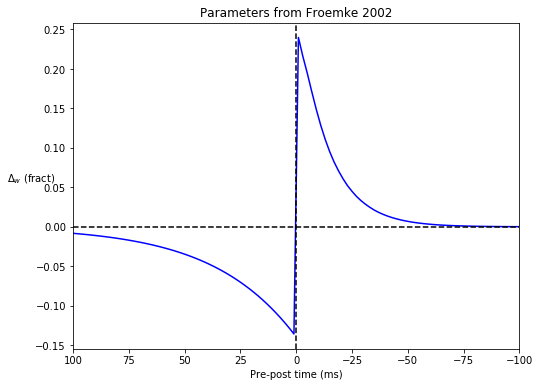

In [10]:
import logging
import math
import numpy
import pylab
import random
import sys
from pyNN.parameters import Sequence
import pyNN.nest as sim
import numpy as np
import matplotlib.pyplot as plt

#VOIR BI AND PO 98 POUR LES DATAS
time_between_pairs = 1000
num_pairs = 60
start_w = .5
delta_t = np.linspace(100, -100, 100, dtype=int)

start_time = 200

def simulate(sim, tau_minus, setup_kwargs):
    # Population parameters
    tau_plus = tau_minus
    model = sim.IF_curr_exp
    cell_params = {'cm': 0.25,  # nF
                   'i_offset': 0.0,
                   'tau_m': 10.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 2.5,
                   'tau_syn_I': 2.5,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -55.4}

    # SpiNNaker setup
    sim.setup(timestep=0.1, **setup_kwargs)
    sim_time = (num_pairs * time_between_pairs) + max(delta_t)

    # Neuron populations
    pre_pop = sim.Population(len(delta_t), model(**cell_params), label="pre")
    post_pop = sim.Population(len(delta_t), model(**cell_params), label="post")

    # Stimulating populations
    pre_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="pre_stim")
    post_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="post_stim")

    # Build stimulus spike times
    for i, t in enumerate(delta_t):
        # Pre after post
        if t > 0:
            post_phase = start_time
            pre_phase = start_time + t + 1
        # Post after pre
        else:
            post_phase = start_time - t
            pre_phase = start_time + 1

        pre_stim[i].spike_times = Sequence(
            range(pre_phase, sim_time, time_between_pairs))
        post_stim[i].spike_times = Sequence(
            range(post_phase, sim_time, time_between_pairs))

    # Connections between spike sources and neuron populations
    ee_connector = sim.OneToOneConnector()
    ee_synapse = sim.StaticSynapse(weight=2.0, delay=1.0)
    sim.Projection(pre_stim, pre_pop, ee_connector, ee_synapse)
    sim.Projection(post_stim, post_pop, ee_connector, ee_synapse)

    timing_dependence = sim.SpikePairRule(tau_plus=13.3, tau_minus=34.5,
                                          A_plus=.005, A_minus=.0025)

    # Plastic Connection between pre_pop and post_pop
    stdp_model = sim.STDPMechanism(
        timing_dependence=timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=start_w*2),  # 200% max voir papier
        weight=start_w,
        delay=1,
        dendritic_delay_fraction=1.)

    plastic_proj = sim.Projection(
        pre_pop, post_pop, sim.OneToOneConnector(), stdp_model)

    sim.run(sim_time)

    end_w = plastic_proj.get("weight", format="list", with_address=False)

    sim.end()

    return end_w


figure, axis = plt.subplots(figsize=(8, 6))
axis.set_xlabel(r"Pre-post time (ms)")
axis.set_ylabel(r"$\Delta_w$ (fract)", rotation="horizontal")


end_w = simulate(sim, tau_minus, {"spike_precision": "on_grid"})

delta_w = [(w - start_w) / start_w for w in end_w]
axis.plot(delta_t, delta_w,
          color='b')
axis.set_xlim(100, -100)  # problème de simulation, faut inverser les poids

axis.axhline(color="k", linestyle="--")
axis.axvline(color="k", linestyle="--")
plt.title('Parameters from Froemke 2002')
plt.savefig('./figs/2018_12_19_STDP_Froemke_2002.pdf')
plt.show()

In [11]:
sim.SpikePairRule?

# STDP Hebienne causale

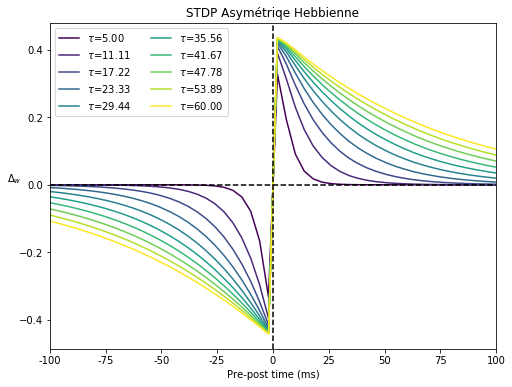

In [12]:
import logging
import math
import numpy
import pylab
import random
import sys
from pyNN.parameters import Sequence
import pyNN.nest as sim
import numpy as np
import matplotlib.pyplot as plt

#VOIR BI AND PO 98 POUR LES DATAS
time_between_pairs = 1000
num_pairs = 60
start_w = .5
delta_t = np.linspace(-100, 100, 50, dtype=int)

start_time = 200

def simulate(sim, tau_minus, setup_kwargs):
    # Population parameters
    tau_plus = tau_minus
    model = sim.IF_curr_exp
    cell_params = {'cm': 0.25,  # nF
                   'i_offset': 0.0,
                   'tau_m': 10.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 2.5,
                   'tau_syn_I': 2.5,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -55.4}

    # SpiNNaker setup
    sim.setup(timestep=0.1, **setup_kwargs)
    sim_time = (num_pairs * time_between_pairs) + max(delta_t)

    # Neuron populations
    pre_pop = sim.Population(len(delta_t), model(**cell_params), label="pre")
    post_pop = sim.Population(len(delta_t), model(**cell_params), label="post")

    # Stimulating populations
    pre_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="pre_stim")
    post_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="post_stim")

    # Build stimulus spike times
    for i, t in enumerate(delta_t):
        # Pre after post
        if t > 0:
            post_phase = start_time
            pre_phase = start_time + t + 1
        # Post after pre
        else:
            post_phase = start_time - t
            pre_phase = start_time + 1

        pre_stim[i].spike_times = Sequence(
            range(pre_phase, sim_time, time_between_pairs))
        post_stim[i].spike_times = Sequence(
            range(post_phase, sim_time, time_between_pairs))

    # Connections between spike sources and neuron populations
    ee_connector = sim.OneToOneConnector()
    ee_synapse = sim.StaticSynapse(weight=2.0, delay=1.0)
    sim.Projection(pre_stim, pre_pop, ee_connector, ee_synapse)
    sim.Projection(post_stim, post_pop, ee_connector, ee_synapse)

    timing_dependence = sim.SpikePairRule(tau_plus=tau_plus, tau_minus=tau_minus,
                                          A_plus=.01, A_minus=.01)

    # Plastic Connection between pre_pop and post_pop
    stdp_model = sim.STDPMechanism(
        timing_dependence=timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=start_w*2),  # 200% max voir papier
        weight=start_w,
        delay=1,
        dendritic_delay_fraction=1.)

    plastic_proj = sim.Projection(
        pre_pop, post_pop, sim.OneToOneConnector(), stdp_model)

    sim.run(sim_time)

    end_w = plastic_proj.get("weight", format="list", with_address=False)

    sim.end()

    return end_w


figure, axis = plt.subplots(figsize=(8, 6))
axis.set_xlabel(r"Pre-post time (ms)")
axis.set_ylabel(r"$\Delta_w$", rotation="horizontal")

colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i, tau_minus in enumerate(np.linspace(5, 60, 10)):
    end_w = simulate(sim, tau_minus, {"spike_precision": "on_grid"})

    delta_w = [(w - start_w) / start_w for w in end_w]
    axis.plot(delta_t, delta_w, label="$\\tau$=%.2f" % tau_minus,
              color=colors[i])
    axis.set_xlim(100, -100)  # problème de simulation, faut inverser les X

a = np.linspace(-100, 0, 5, dtype = int) 
b = np.linspace(25, 100, 4, dtype = int)
ab = np.concatenate((a, b))
axis.set_xticklabels(-ab) #et on le corrige dans le labelling

axis.axhline(color="k", linestyle="--")
axis.axvline(color="k", linestyle="--")
axis.legend(loc = 2, ncol = 2 )
plt.title('STDP Asymétriqe Hebbienne')
plt.savefig('./figs/2018_12_20_STDP_asym_heb.pdf', format = 'pdf', dpi = 200)
plt.show()

# STDP Anti-Hebienne, anticausale
On met un petit moins devant chaque A * pour inverser les courbes tout simplement

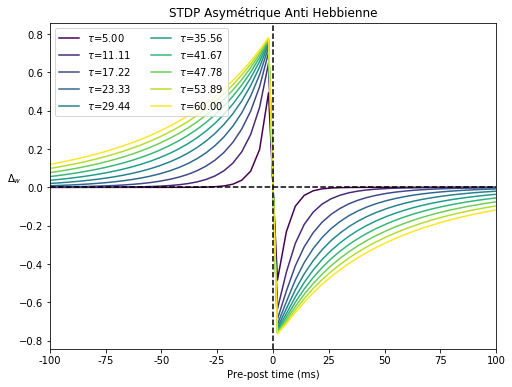

In [13]:
import logging
import math
import numpy
import pylab
import random
import sys
from pyNN.parameters import Sequence
import pyNN.nest as sim
import numpy as np
import matplotlib.pyplot as plt

#VOIR BI AND PO 98 POUR LES DATAS
time_between_pairs = 1000
num_pairs = 60
start_w = .5
delta_t = np.linspace(-100, 100, 50, dtype=int)

start_time = 200

def simulate(sim, tau_minus, setup_kwargs):
    # Population parameters
    tau_plus = tau_minus
    model = sim.IF_curr_exp
    cell_params = {'cm': 0.25,  # nF
                   'i_offset': 0.0,
                   'tau_m': 10.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 2.5,
                   'tau_syn_I': 2.5,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -55.4}

    # SpiNNaker setup
    sim.setup(timestep=0.1, **setup_kwargs)
    sim_time = (num_pairs * time_between_pairs) + max(delta_t)

    # Neuron populations
    pre_pop = sim.Population(len(delta_t), model(**cell_params), label="pre")
    post_pop = sim.Population(len(delta_t), model(**cell_params), label="post")

    # Stimulating populations
    pre_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="pre_stim")
    post_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="post_stim")

    # Build stimulus spike times
    for i, t in enumerate(delta_t):
        # Pre after post
        if t > 0:
            post_phase = start_time
            pre_phase = start_time + t + 1
        # Post after pre
        else:
            post_phase = start_time - t
            pre_phase = start_time + 1

        pre_stim[i].spike_times = Sequence(
            range(pre_phase, sim_time, time_between_pairs))
        post_stim[i].spike_times = Sequence(
            range(post_phase, sim_time, time_between_pairs))

    # Connections between spike sources and neuron populations
    ee_connector = sim.OneToOneConnector()
    ee_synapse = sim.StaticSynapse(weight=2.0, delay=1.0)
    sim.Projection(pre_stim, pre_pop, ee_connector, ee_synapse)
    sim.Projection(post_stim, post_pop, ee_connector, ee_synapse)

    timing_dependence = sim.SpikePairRule(tau_plus=tau_plus, tau_minus=tau_minus,
                                          A_plus=-.01, A_minus=-.01)

    # Plastic Connection between pre_pop and post_pop
    stdp_model = sim.STDPMechanism(
        timing_dependence=timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=start_w*2),  # 200% max voir papier
        weight=start_w,
        delay=1,
        dendritic_delay_fraction=1.)

    plastic_proj = sim.Projection(
        pre_pop, post_pop, sim.OneToOneConnector(), stdp_model)

    sim.run(sim_time)

    end_w = plastic_proj.get("weight", format="list", with_address=False)

    sim.end()

    return end_w


figure, axis = plt.subplots(figsize=(8, 6))
axis.set_xlabel(r"Pre-post time (ms)")
axis.set_ylabel(r"$\Delta_w$", rotation="horizontal")

colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i, tau_minus in enumerate(np.linspace(5, 60, 10)):
    end_w = simulate(sim, tau_minus, {"spike_precision": "on_grid"})

    delta_w = [(w - start_w) / start_w for w in end_w]
    axis.plot(delta_t, delta_w, label="$\\tau$=%.2f" % tau_minus,
              color=colors[i])
    axis.set_xlim(100, -100)  # problème de simulation, faut inverser les X

a = np.linspace(-100, 0, 5, dtype = int) 
b = np.linspace(25, 100, 4, dtype = int)
ab = np.concatenate((a, b))
axis.set_xticklabels(-ab) #et on le corrige dans le labelling
axis.axhline(color="k", linestyle="--")
axis.axvline(color="k", linestyle="--")
axis.legend(loc = 2, ncol = 2 )
plt.title('STDP Asymétrique Anti Hebbienne')
plt.savefig('./figs/2018_12_20_STDP_asym_antiheb.pdf', format = 'pdf', dpi = 200)
plt.show()

# STDP Positive et symétrique
La on met un moins devant le A*-

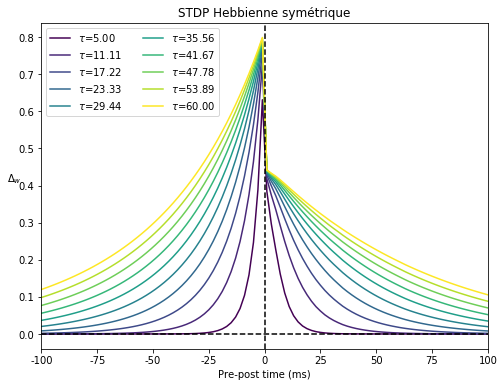

In [14]:
import logging
import math
import numpy
import pylab
import random
import sys
from pyNN.parameters import Sequence
import pyNN.nest as sim
import numpy as np
import matplotlib.pyplot as plt

#VOIR BI AND PO 98 POUR LES DATAS
time_between_pairs = 1000
num_pairs = 60
start_w = .5
delta_t = np.linspace(-100, 100, 100, dtype=int)

start_time = 200

def simulate(sim, tau_minus, setup_kwargs):
    # Population parameters
    tau_plus = tau_minus
    model = sim.IF_curr_exp
    cell_params = {'cm': 0.25,  # nF
                   'i_offset': 0.0,
                   'tau_m': 10.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 2.5,
                   'tau_syn_I': 2.5,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -55.4}

    # SpiNNaker setup
    sim.setup(timestep=0.1, **setup_kwargs)
    sim_time = (num_pairs * time_between_pairs) + max(delta_t)

    # Neuron populations
    pre_pop = sim.Population(len(delta_t), model(**cell_params), label="pre")
    post_pop = sim.Population(len(delta_t), model(**cell_params), label="post")

    # Stimulating populations
    pre_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="pre_stim")
    post_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="post_stim")

    # Build stimulus spike times
    for i, t in enumerate(delta_t):
        # Pre after post
        if t > 0:
            post_phase = start_time
            pre_phase = start_time + t + 1
        # Post after pre
        else:
            post_phase = start_time - t
            pre_phase = start_time + 1

        pre_stim[i].spike_times = Sequence(
            range(pre_phase, sim_time, time_between_pairs))
        post_stim[i].spike_times = Sequence(
            range(post_phase, sim_time, time_between_pairs))

    # Connections between spike sources and neuron populations
    ee_connector = sim.OneToOneConnector()
    ee_synapse = sim.StaticSynapse(weight=2.0, delay=1.0)
    sim.Projection(pre_stim, pre_pop, ee_connector, ee_synapse)
    sim.Projection(post_stim, post_pop, ee_connector, ee_synapse)

    timing_dependence = sim.SpikePairRule(tau_plus=tau_plus, tau_minus=tau_minus,
                                          A_plus=.01, A_minus=-.01)

    # Plastic Connection between pre_pop and post_pop
    stdp_model = sim.STDPMechanism(
        timing_dependence=timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=start_w*2),  # 200% max voir papier
        weight=start_w,
        delay=1,
        dendritic_delay_fraction=1.)

    plastic_proj = sim.Projection(
        pre_pop, post_pop, sim.OneToOneConnector(), stdp_model)

    sim.run(sim_time)

    end_w = plastic_proj.get("weight", format="list", with_address=False)

    sim.end()

    return end_w


figure, axis = plt.subplots(figsize=(8, 6))
axis.set_xlabel(r"Pre-post time (ms)")
axis.set_ylabel(r"$\Delta_w$", rotation="horizontal")

colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i, tau_minus in enumerate(np.linspace(5, 60, 10)):
    end_w = simulate(sim, tau_minus, {"spike_precision": "on_grid"})

    delta_w = [(w - start_w) / start_w for w in end_w]
    axis.plot(delta_t, delta_w, label="$\\tau$=%.2f" % tau_minus,
              color=colors[i])
    axis.set_xlim(100, -100)  # problème de simulation, faut inverser les X

a = np.linspace(-100, 0, 5, dtype = int) 
b = np.linspace(25, 100, 4, dtype = int)
ab = np.concatenate((a, b))
axis.set_xticklabels(-ab) #et on le corrige dans le labelling
axis.axhline(color="k", linestyle="--")
axis.axvline(color="k", linestyle="--")
axis.legend(loc = 2, ncol = 2 )
plt.title('STDP Hebbienne symétrique')
plt.savefig('./figs/2018_12_20_STDP_sym_heb.pdf', format = 'pdf', dpi = 200)
plt.show()

# STDP Negative et symétrique
La on met un moins devant le A*+

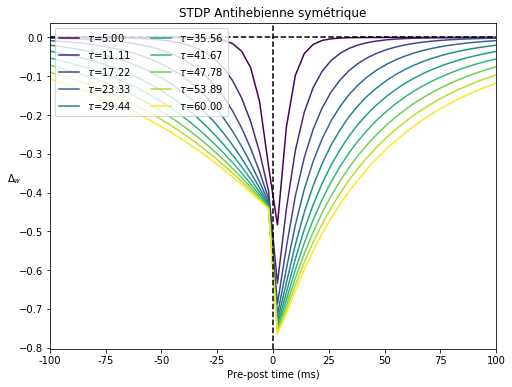

In [3]:
import logging
import math
import numpy
import pylab
import random
import sys
from pyNN.parameters import Sequence
import pyNN.nest as sim
import numpy as np
import matplotlib.pyplot as plt

#VOIR BI AND PO 98 POUR LES DATAS
time_between_pairs = 1000
num_pairs = 60
start_w = .5
delta_t = np.linspace(-100, 100, 50, dtype=int)

start_time = 200

def simulate(sim, tau_minus, setup_kwargs):
    # Population parameters
    tau_plus = tau_minus
    model = sim.IF_curr_exp
    cell_params = {'cm': 0.25,  # nF
                   'i_offset': 0.0,
                   'tau_m': 10.0,
                   'tau_refrac': 2.0,
                   'tau_syn_E': 2.5,
                   'tau_syn_I': 2.5,
                   'v_reset': -70.0,
                   'v_rest': -65.0,
                   'v_thresh': -55.4}

    # SpiNNaker setup
    sim.setup(timestep=0.1, **setup_kwargs)
    sim_time = (num_pairs * time_between_pairs) + max(delta_t)

    # Neuron populations
    pre_pop = sim.Population(len(delta_t), model(**cell_params), label="pre")
    post_pop = sim.Population(len(delta_t), model(**cell_params), label="post")

    # Stimulating populations
    pre_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="pre_stim")
    post_stim = sim.Population(len(delta_t), sim.SpikeSourceArray(
        spike_times=[10]), label="post_stim")

    # Build stimulus spike times
    for i, t in enumerate(delta_t):
        # Pre after post
        if t > 0:
            post_phase = start_time
            pre_phase = start_time + t + 1
        # Post after pre
        else:
            post_phase = start_time - t
            pre_phase = start_time + 1

        pre_stim[i].spike_times = Sequence(
            range(pre_phase, sim_time, time_between_pairs))
        post_stim[i].spike_times = Sequence(
            range(post_phase, sim_time, time_between_pairs))

    # Connections between spike sources and neuron populations
    ee_connector = sim.OneToOneConnector()
    ee_synapse = sim.StaticSynapse(weight=2.0, delay=1.0)
    sim.Projection(pre_stim, pre_pop, ee_connector, ee_synapse)
    sim.Projection(post_stim, post_pop, ee_connector, ee_synapse)

    timing_dependence = sim.SpikePairRule(tau_plus=tau_plus, tau_minus=tau_minus,
                                          A_plus=-.01, A_minus=.01)

    # Plastic Connection between pre_pop and post_pop
    stdp_model = sim.STDPMechanism(
        timing_dependence=timing_dependence,
        weight_dependence=sim.MultiplicativeWeightDependence(
            w_min=0, w_max=start_w*2),  # 200% max voir papier
        weight=start_w,
        delay=1,
        dendritic_delay_fraction=1.)

    plastic_proj = sim.Projection(
        pre_pop, post_pop, sim.OneToOneConnector(), stdp_model)

    sim.run(sim_time)

    end_w = plastic_proj.get("weight", format="list", with_address=False)

    sim.end()

    return end_w


figure, axis = plt.subplots(figsize=(8, 6))
axis.set_xlabel(r"Pre-post time (ms)")
axis.set_ylabel(r"$\Delta_w$", rotation="horizontal")

colors = plt.cm.viridis(np.linspace(0, 1, 10))
for i, tau_minus in enumerate(np.linspace(5, 60, 10)):
    end_w = simulate(sim, tau_minus, {"spike_precision": "on_grid"})

    delta_w = [(w - start_w) / start_w for w in end_w]
    axis.plot(delta_t, delta_w, label="$\\tau$=%.2f" % tau_minus,
              color=colors[i])
    axis.set_xlim(100, -100)  # problème de simulation, faut inverser les X

a = np.linspace(-100, 0, 5, dtype = int) 
b = np.linspace(25, 100, 4, dtype = int)
ab = np.concatenate((a, b))
axis.set_xticklabels(-ab) #et on le corrige dans le labelling
axis.axhline(color="k", linestyle="--")
axis.axvline(color="k", linestyle="--")
axis.legend(loc = 2, ncol = 2 )
plt.title('STDP Antihebienne symétrique')
plt.savefig('./figs/2018_12_20_STDP_sym_antiheb.pdf', format = 'pdf', dpi = 200)
plt.show()